## CandidateBios Data Accuracy

Created by Victor Verma

Last edited May 7, 2024

This file was used to assess the accuracy of the biodata outputs using various
machine-learning techniques including random forests, k-nearest neighbors,
xgboost, and neural networks.


In [ ]:
# Install Necessary Packages
%pip install matplotlib
%pip install pandas
%pip install seaborn
%pip install sklearn
%pip install tensorflow
%pip install xgboost

In [3]:
# Imports

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Sequential
from xgboost import XGBClassifier

2024-04-05 19:50:14.378729: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Global Variables

accuracyData = "./accuracyTraining.csv"
accuracyData2 = "./accuracyTraining(w_oconfidence).csv"
accuracyData3 = "./accuracyTrainingMerge.csv"
sourceData = accuracyData3

modelMap = {
    "NN": {"name": "neural network"},
    "RF": {"name": "random forest"},
    "XG": {"name": "xgboost"},
    "KN": {"name": "k-nearest neighbors"},
}

In [5]:
# Data Accuracy


def readData(file, include):
    """
    Description
        - Reads the csv containing the source data and creates a dataframe that
        contains the desired information.
    Parameters
        - file: a string representing the path to the csv containing the source
        data.
        - include: a string that indicates whether to include candidate output
        rows with no data. If include is set to “all”, then all output rows are
        included. If include is set to “output”, only the rows with some output
        present are included. If include is set to “1998+”, only the rows for
        candidates with min year of 1998 or later are included.
    Return
        - A pandas dataframe containing the accuracy training data.
    """

    # verifies parameters
    assert include in ["all", "output", "1998+"]

    # reads all candidate output rows
    if include == "all":
        df = pd.read_csv(file, index_col=None, encoding="latin-1")
        print(f"training data has {len(df)} candidates\n")

    # only reads candidate output rows with data
    elif include == "output":
        df = pd.read_csv(file, index_col=None, encoding="latin-1")
        df = df.drop(
            df[
                (pd.isnull(df["College Major"]))
                & (pd.isnull(df["Undergraduate Institution"]))
                & (pd.isnull(df["Highest Degree and Institution"]))
                & (pd.isnull(df["Work History"]))
            ].index
        )
        print(f"output-only training data has {len(df)} candidates\n")

    # only reads candidate output rows after 1998
    elif include == "1998+":
        df = pd.read_csv(file, index_col=None, encoding="latin-1")
        df = df[df["Min Year"] >= 1998]
        print(f"1998+ training data has {len(df)} candidates\n")
    return df


def prepareData(data):
    """
    Description
        - Prepares the training data for the machine-learning models by
        encoding string datatypes and dropping unnecessary columns.
    Parameters
        - data: a pandas dataframe containing the accuracy training data.
    Return
        - The processed dataframe.
    """

    # encodes all columns with string datatype
    for column in [
        "Name",
        "State",
        "College Major",
        "Undergraduate Institution",
        "Highest Degree and Institution",
        "Work History",
        "Sources",
        "Party",
    ]:
        data[column] = data[column].astype("category").cat.codes

    # drops unnecessary column
    data.drop("Candid", axis=1, inplace=True)

    return data


def trainModel(X_train, y_train, modelType, include):
    """
    Description
        - Trains the specified machine-learning model based on the training data.
    Parameters
        - X_train: an array containing the training data for the features.
        - y_train: an array of binary values representing the training classifications.
        - modelType: a string specifying the type of machine-learning model being
        trained. “NN” indicates neural network, “RF” indicates random forest,
        “XG” indicates XGBoost, and “KN” indicates k-nearest neighbors.
        - include: a string that indicates whether to include candidate output
        rows with no data. If include is set to “all”, then all output rows are
        included. If include is set to “output”, only the rows with some output
        present are included. If include is set to “1998+”, only the rows for
        candidates with min year of 1998 or later are included.
    Return
        - A machine-learning model as specified by the modelType and trained on
        the accuracy data.
    """

    # verifies parameters
    assert modelType in ["NN", "RF", "XG", "KN"]

    # trains neural network model
    if modelType == "NN":
        if include == "all":
            model = Sequential(
                [
                    Input(shape=X_train.shape[1]),
                    layers.Dense(64, activation="relu"),
                    layers.Dropout(0.2),
                    layers.Dense(32, activation="relu"),
                    layers.Dropout(0.2),
                    layers.Dense(16, activation="relu"),
                    layers.Dropout(0.2),
                    layers.Dense(1, activation="sigmoid"),
                ]
            )
            model.compile(
                optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
            )
            model.fit(X_train, y_train, epochs=35, batch_size=64)
        elif include == "output" or include == "1998+":
            model = Sequential(
                [
                    Input(shape=X_train.shape[1]),
                    layers.Dense(32, activation="relu"),
                    layers.Dropout(0.2),
                    layers.Dense(16, activation="relu"),
                    layers.Dropout(0.2),
                    layers.Dense(1, activation="sigmoid"),
                ]
            )
            model.compile(
                optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
            )
            model.fit(X_train, y_train, epochs=18, batch_size=32)

    # trains random forest model
    elif modelType == "RF":
        if include == "all":
            params = {
                "n_estimators": 100,
                "min_samples_split": 5,
                "min_samples_leaf": 5,
                "max_features": "sqrt",
                "max_depth": 10,
                "bootstrap": True,
            }
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)

    # trains XGBoost model
    elif modelType == "XG":
        model = XGBClassifier()
        model.fit(X_train, y_train)

    # trains k-nearest neighbors model
    elif modelType == "KN":
        if include == "all":
            params = {
                "n_neighbors": 7,
                "weights": "uniform",
                "algorithm": "auto",
                "metric": "euclidean",
                "leaf_size": 30,
                "n_jobs": -1,
            }
        model = KNeighborsClassifier(**params)
        model.fit(X_train, y_train)

    return model


def evaluateModel(model, modelType, X_test, y_test, confusionMatrix):
    """
    Description
        - Evaluates the accuracy and f1 score of the model on the testing data
        and prints the classification report and confusion matrix.
    Parameters
        - model: a machine-learning model.
        - modelType: a string specifying the type of machine-learning model being
        trained. “NN” indicates neural network, “RF” indicates random forest,
        “XG” indicates XGBoost, and “KN” indicates k-nearest neighbors.
        - X_test: an array containing the testing data for the features.
        - y_test: an array of binary values representing the output of the testing
        data.
        - confusionMatrix: a boolean value indicating if the confusion matrix should
        be printed.
    Return
        - A float indicating the accuracy of the model on the testing data.
    """

    # verifies parameters
    assert modelType in ["NN", "RF", "XG", "KN"]
    assert confusionMatrix in [True, False]

    # performs k-fold cross-validation testing
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    f1_scores = cross_val_score(model, X_test, y_test, cv=skf, scoring="f1")

    # calculates f1 scores
    print(f"{modelMap[modelType]['name']} 5-fold cross-validated f1 scores:", f1_scores)
    print(
        f"{modelMap[modelType]['name']} mean 5-fold cross-validated f1 score:",
        f1_scores.mean(),
    )

    # creates classification report
    y_test_predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_predictions)
    print(classification_report(y_test, y_test_predictions))

    # creates confusion matrix
    cm = confusion_matrix(y_test, y_test_predictions)
    sns.heatmap(cm, annot=True)
    plt.title("Test Set Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return accuracy


def validateModel(validationSet, model, modelType, confusionMatrix):
    """
    Description
        - Evaluates the accuracy and f1 score of the model on the validation data
        and prints the classification report and confusion matrix.
    Parameters
        - validatationSet: a pandas dataframe containing the validation data.
        - model: a machine-learning model.
        - modelType: a string specifying the type of machine-learning model being
        trained. “NN” indicates neural network, “RF” indicates random forest,
        “XG” indicates XGBoost, and “KN” indicates k-nearest neighbors.
        - validationSet: a pandas dataframe containing the validation data.
        confusionMatrix: a boolean value indicating if the confusion matrix should be
        printed.
    Return
        - A float indicating the accuracy of the model on the validation data.
    """

    # verifies parameters
    assert modelType in ["NN", "RF", "XG", "KN"]
    assert confusionMatrix in [True, False]

    # defines features and target
    X_validate = validationSet.iloc[:, :-1]
    y_validate = validationSet["Accuracy"]

    # creates classification report
    y_validate_predictions = model.predict(X_validate)
    accuracy = accuracy_score(y_validate, y_validate_predictions)
    print(classification_report(y_validate, y_validate_predictions))

    # creates confusion matrix
    cm = confusion_matrix(y_validate, y_validate_predictions)
    sns.heatmap(cm, annot=True)
    plt.title("Validation Set Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return accuracy

In [9]:
# reads the data
data = readData(accuracyData3, "all")
print(data.head())

# prepares the data
preparedData = prepareData(data)
print(preparedData.head())

trainTestSet = data.iloc[:745]
validationSet = data.iloc[745:]

# defines features and target
X = trainTestSet.iloc[:, :-1]
y = trainTestSet["Accuracy"]

# performs train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# trains the model
model = trainModel(X_train, y_train, "XG", "all")

training data has 876 candidates

                  Name  State  Min Year  Candid College Major  \
0     emily traskeaton  Maine      1982  100026           NaN   
1  christina a tirrell  Maine      1988  100662           NaN   
2        elaine fuller  Maine      1994  100788           NaN   
3       frank a quimby  Maine      1968  101043           NaN   
4  mary d mayowestcott  Maine      2002  101452           NaN   

  Undergraduate Institution  \
0                       NaN   
1                       NaN   
2                       NaN   
3                       NaN   
4                       NaN   

                      Highest Degree and Institution  \
0  Doctor of Osteopathic Medicine, University of ...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                        Work Histor

xgboost 5-fold cross-validated f1 scores: [0.74285714 0.76470588 0.8        0.75       0.78787879]
xgboost mean 5-fold cross-validated f1 score: 0.7690883626177744
              precision    recall  f1-score   support

           0       0.43      0.33      0.38        30
           1       0.78      0.84      0.81        82

    accuracy                           0.71       112
   macro avg       0.61      0.59      0.59       112
weighted avg       0.68      0.71      0.69       112



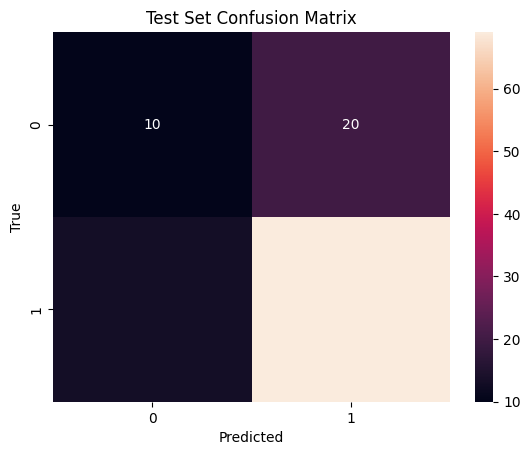

0.7053571428571429

In [10]:
# evaluates the model on the testing set
evaluateModel(model, "XG", X_test, y_test, True)

              precision    recall  f1-score   support

           0       0.47      0.38      0.42        37
           1       0.77      0.83      0.80        94

    accuracy                           0.70       131
   macro avg       0.62      0.60      0.61       131
weighted avg       0.69      0.70      0.69       131



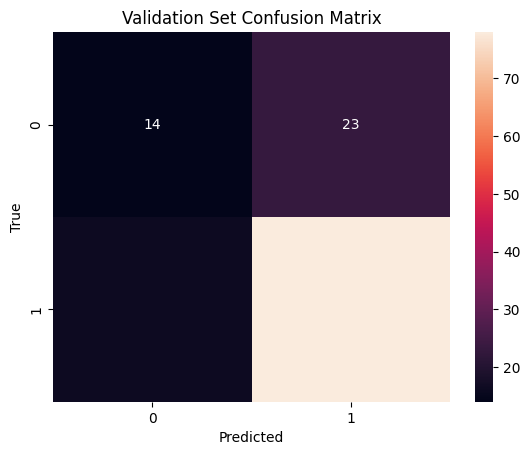

0.7022900763358778

In [11]:
# validates the model on the validation set
validateModel(validationSet, model, "XG", True)